In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

from fastai import *
from fastai.vision import *
from superRes.generators import *
from superRes.critics import *
from superRes.dataset import *
from superRes.loss import *
from superRes.save import *
from superRes.fid_loss import *
from superRes.ssim import *
from superRes.metrics import *


import torchvision
import geffnet # efficient/ mobile net

In [16]:
def do_fit(learn, epochs,save_name, lrs=slice(1e-3), pct_start=0.3):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learn.save("/data/students_home/fmameli/repos/SuperRes/models/" + save_name)
    learn.show_results(rows=1, imgsize=10)

In [3]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'

path_lowRes_256 = path/'DIV2K_train_LR_256_QF20'
path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'
path_lowRes_Full = path/'DIV2K_train_LR_Full_QF20'

proj_id = 'unet_superRes_mobilenetV3_SSIM'

gen_name = proj_id + '_gen'
crit_name = proj_id + '_crit'

nf_factor = 2
pct_start = 1e-8

In [4]:
model = geffnet.mobilenetv3_rw
# model = models.resnet34
# model= geffnet.efficientnet_b4

In [5]:
# loss_func = FeatureLoss()
loss_func = SSIM()
# loss_func = calculate_frechet_distance

# 256px

In [10]:
bs=5
sz=256
lr = 1e-2
wd = 1e-3
epochs = 1

In [11]:
data_gen = get_DIV2k_data_QF(path_lowRes_256, path_fullRes, bs=bs, sz=sz)

In [9]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=nf_factor)

In [10]:
learn_gen.metrics.append(SSIM_Metric_gen())
learn_gen.metrics.append(SSIM_Metric_input())
learn_gen.metrics.append(LPIPS_Metric_gen())
learn_gen.metrics.append(LPIPS_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_gen())
learn_gen.metrics.append(BRISQUE_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_target())
learn_gen.metrics.append(NIQE_Metric_gen())
learn_gen.metrics.append(NIQE_Metric_input())
learn_gen.metrics.append(NIQE_Metric_target())

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done
Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [11]:
wandbCallbacks = False

if wandbCallbacks:
    import wandb
    from wandb.fastai import WandbCallback
    config={"batch_size": bs,
            "img_size": (sz, sz),
            "learning_rate": lr,
            "weight_decay": wd,
            "num_epochs": epochs
    }
    wandb.init(project='SuperRes', config=config, id="gen_mobilenetV3_SSIM"+ datetime.now().strftime('_%m-%d_%H:%M'))

    learn_gen.callback_fns.append(partial(WandbCallback, input_type='images'))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


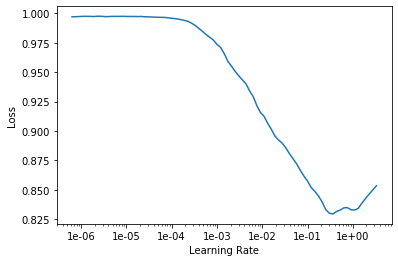

In [14]:
learn_gen.lr_find()
learn_gen.recorder.plot()
# learn_gen.summary()

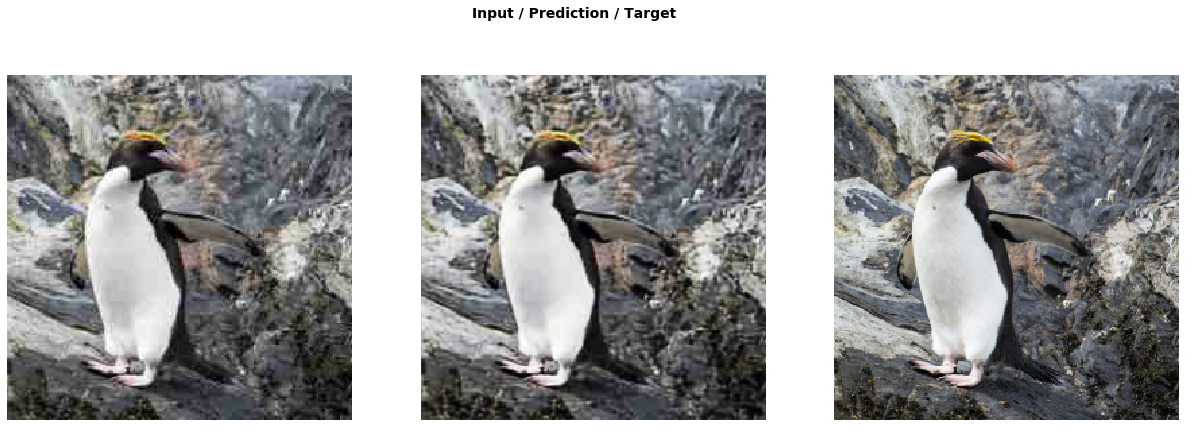

In [15]:
do_fit(learn_gen, 5, gen_name+"_256px_0", slice(lr*10), pct_start=0.8)

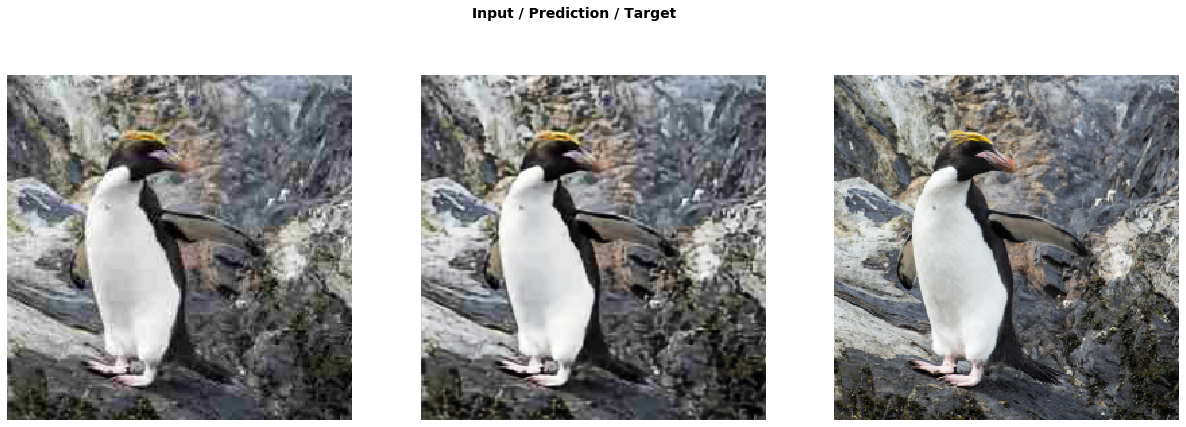

In [16]:
do_fit(learn_gen, 5, gen_name+"_256px_0", slice(lr), pct_start=0.5)

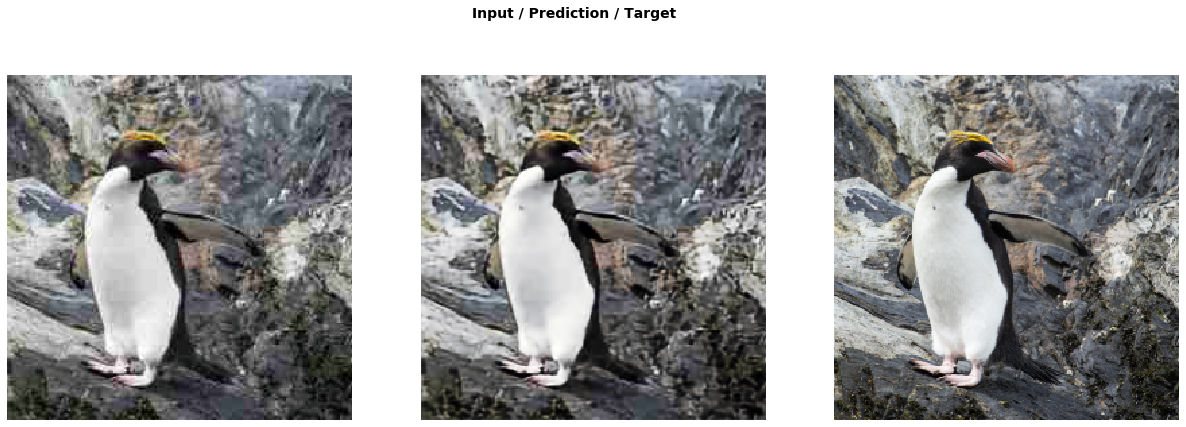

In [17]:
do_fit(learn_gen, 5, gen_name+"_256px_0", slice(1e-3), pct_start=0.3)

In [18]:
learn_gen.unfreeze()

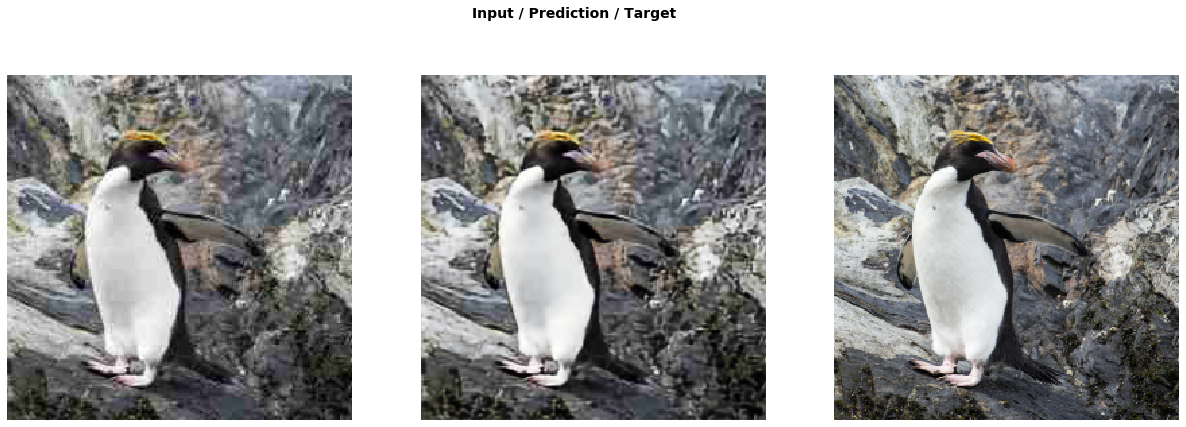

In [19]:
do_fit(learn_gen, 5, gen_name+"_256px_0", slice(1e-3), pct_start=0.8)

# 512px

In [6]:
bs=2
sz=512
epochs = 5

In [12]:
data_gen = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)

In [13]:
learn_gen.data = data_gen
learn_gen.freeze()
gc.collect()

42

In [14]:
learn_gen.load("/data/students_home/fmameli/repos/SuperRes/models/unet_superRes_mobilenetV3_SSIM_gen_512px_0")

Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


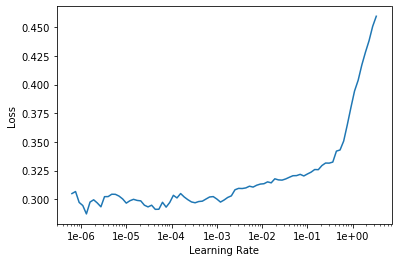

In [23]:
learn_gen.lr_find()
learn_gen.recorder.plot()

Upsize to gen_512


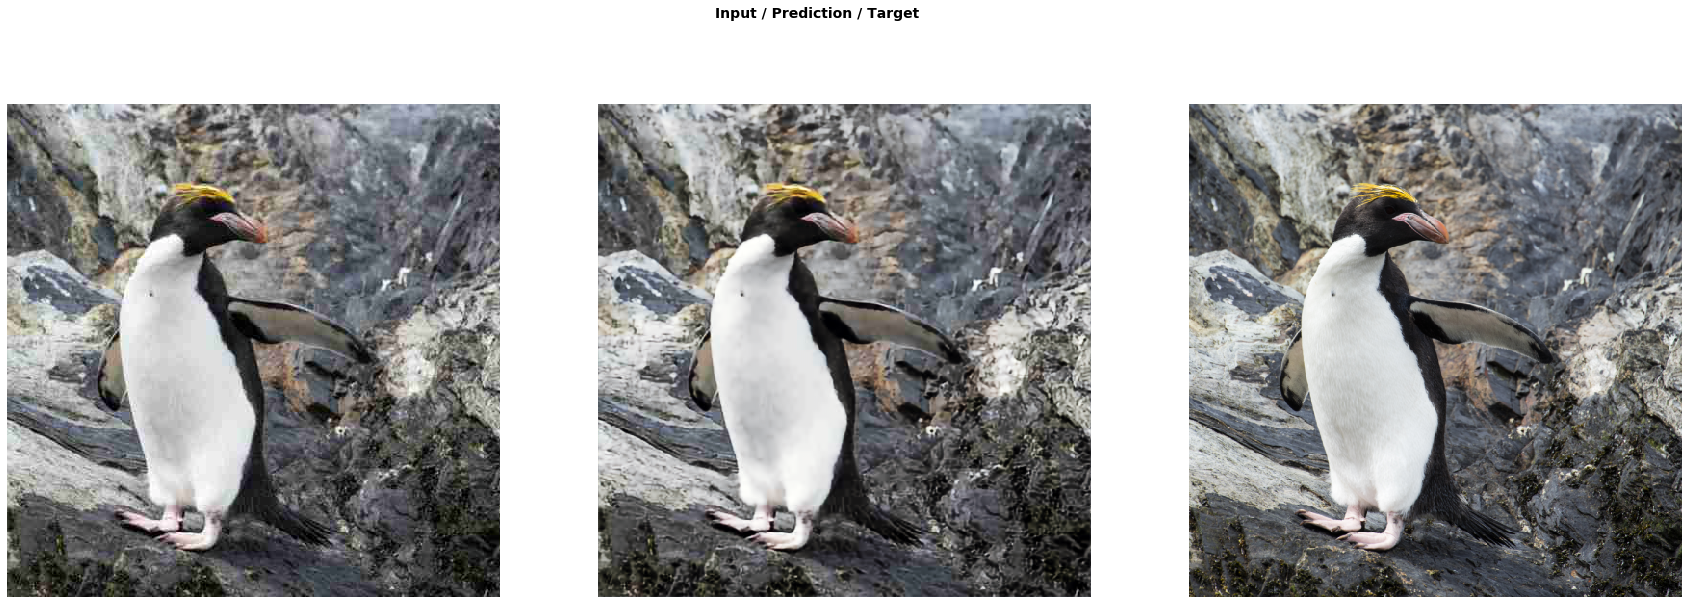

In [17]:
print("Upsize to gen_512")

do_fit(learn_gen, 5, gen_name+"_512px_best", slice(1e-3), pct_start=0.3)

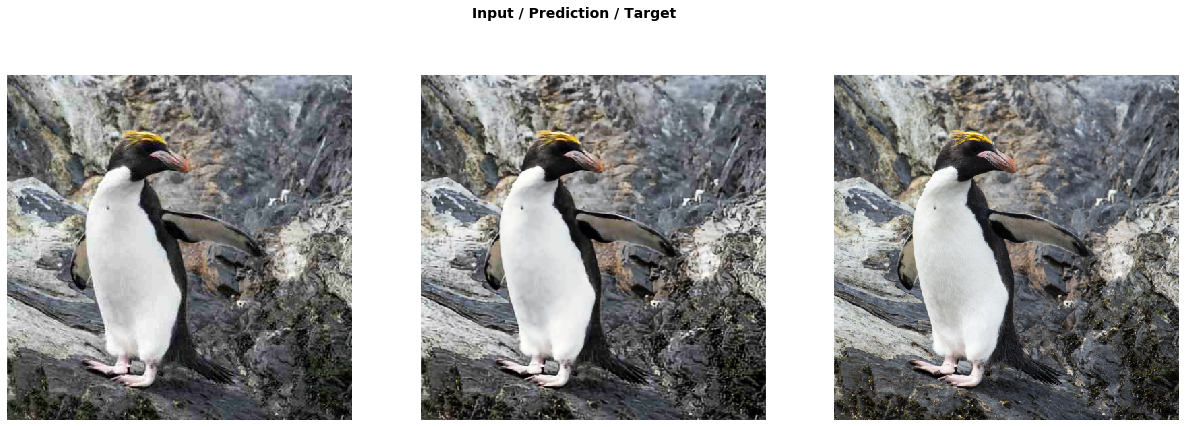

In [25]:
do_fit(learn_gen, 5, gen_name+"_512px_best", slice(1e-4), pct_start=0.3)

In [26]:
learn_gen.unfreeze()

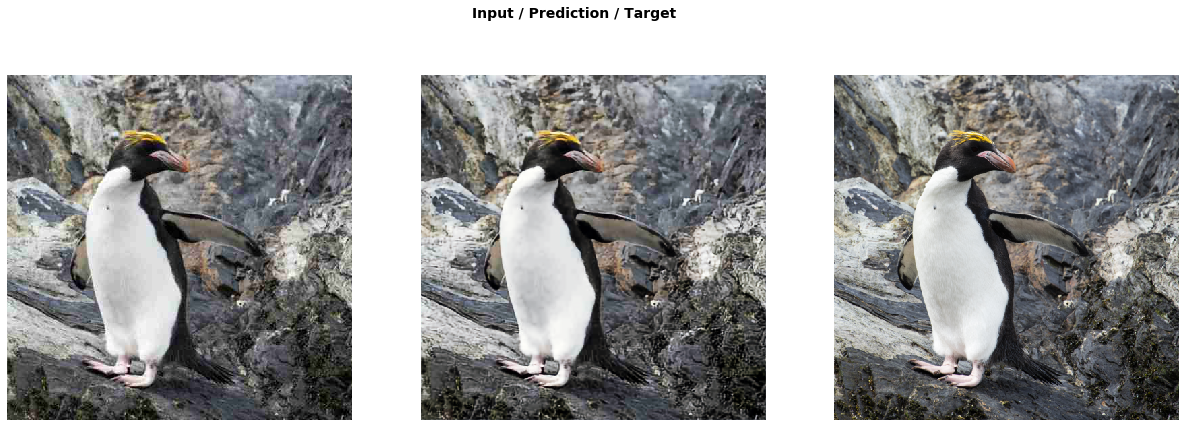

In [27]:
do_fit(learn_gen, 3, gen_name+"_512px_best", slice(1e-5), pct_start=0.3)

# Validation

In [3]:
bs=2
sz=512
epochs = 1

In [4]:
data_gen = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)

In [7]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=SSIM(),
                             arch = geffnet.mobilenetv3_rw,
                             nf_factor=nf_factor)

In [8]:
learn_gen.metrics.append(SSIM_Metric_gen())
learn_gen.metrics.append(SSIM_Metric_input())
learn_gen.metrics.append(LPIPS_Metric_gen())
learn_gen.metrics.append(LPIPS_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_gen())
learn_gen.metrics.append(BRISQUE_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_target())
learn_gen.metrics.append(NIQE_Metric_gen())
learn_gen.metrics.append(NIQE_Metric_input())
learn_gen.metrics.append(NIQE_Metric_target())

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done
Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [9]:
learn_gen.load("/data/students_home/fmameli/repos/SuperRes/models/unet_superRes_mobilenetV3_SSIM_gen_512px_0")

Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
 

In [10]:
val = learn_gen.validate()

In [11]:
for name, m in zip(learn_gen.metrics, val[1:]):
    if isinstance(m, torch.Tensor):
        print(name, m.item())
    else:
        print(name, m)

SSIM_Metric_gen 0.7354809641838074
SSIM_Metric_input 0.7075173854827881
LPIPS_Metric_gen 0.18301184475421906
LPIPS_Metric_input 0.1764998435974121
BRISQUE_Metric_gen 85.09529481874183
BRISQUE_Metric_input 87.3549426119021
BRISQUE_Metric_target 85.32215693738695
NIQE_Metric_gen 17.57933
NIQE_Metric_input 17.860744
NIQE_Metric_target 15.693551


# Test

In [44]:
bs=1
sz=512
epochs = 1

In [45]:
path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'
size=( 512, 680)

In [46]:
data_1k = (ImageImageList.from_folder(path_lowRes_512, presort=True).split_by_idxs(
            train_idx=list(range(0, 800)), valid_idx=list(range(800, 900)))
          .label_from_func(lambda x: path_fullRes/x.name.replace(".jpg", ".png"))
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_1k.c = 3

In [47]:
learn_gen = gen_learner_wide(data=data_1k,
                             gen_loss=loss_func,
                             arch = geffnet.mobilenetv3_rw,
                             nf_factor=nf_factor)

In [48]:
learn_gen.load("/data/students_home/fmameli/repos/SuperRes/models/unet_superRes_mobilenetV3_SSIM_gen_512px_0")

Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680)
y: ImageList
Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680)
Path: dataset/DIV2K_train_LR_512_QF20;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680)
y: ImageList
Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680)
Path: dataset/DIV2K_train_LR_512_QF20;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
 

In [49]:
gc.collect()

140

In [50]:
fn = data_1k.valid_dl.x.items[2]; fn

PosixPath('dataset/DIV2K_train_LR_512_QF20/0803.jpg')

In [39]:
fnFull = data_1k.valid_dl.y.items[2]; fnFull

PosixPath('dataset/DIV2K_train_HR/0803.png')

In [ ]:
imgFull = open_image(fnFull); print(img.shape)

In [ ]:
imgFull

In [46]:
imgFull.save('output_imgs/flower_512_original.png')

In [71]:
img = open_image(fn); print(img.shape)
p,img_hr,b = learn_gen.predict(img)

torch.Size([3, 512, 680])


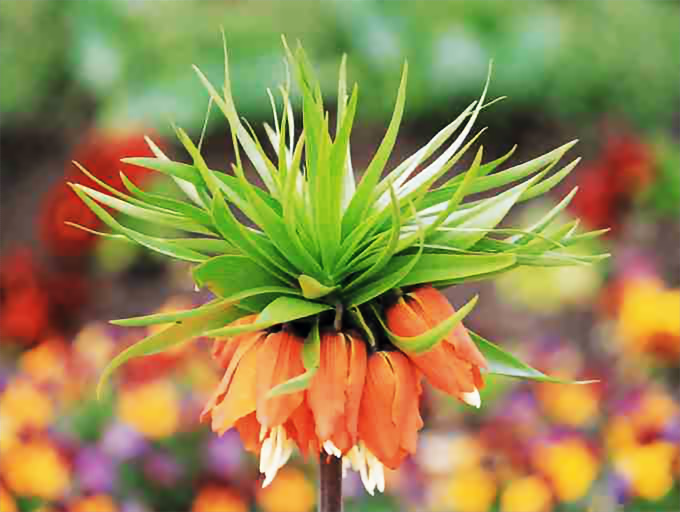

In [72]:
p

In [37]:
img.save('output_imgs/castle_512_validation.png')

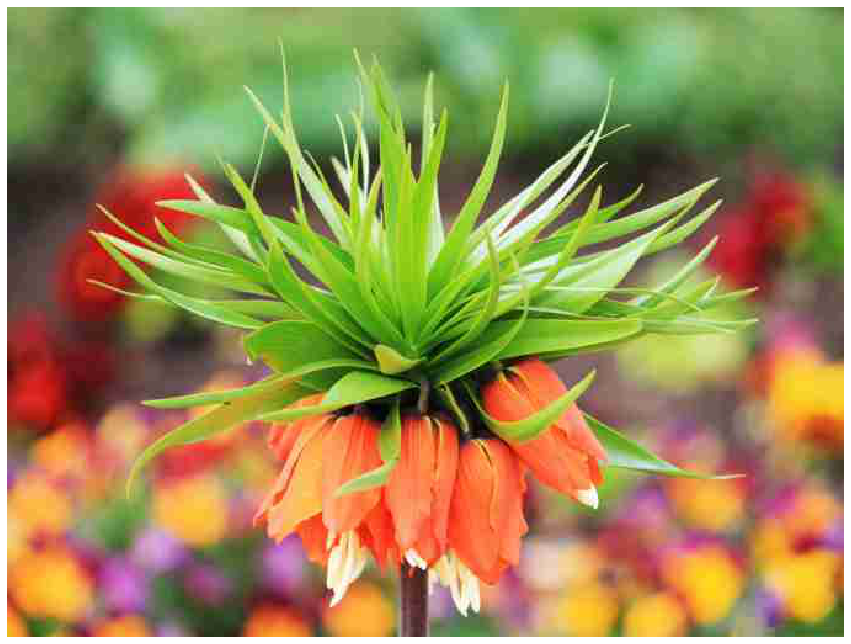

In [53]:
show_image(img, figsize=(15,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


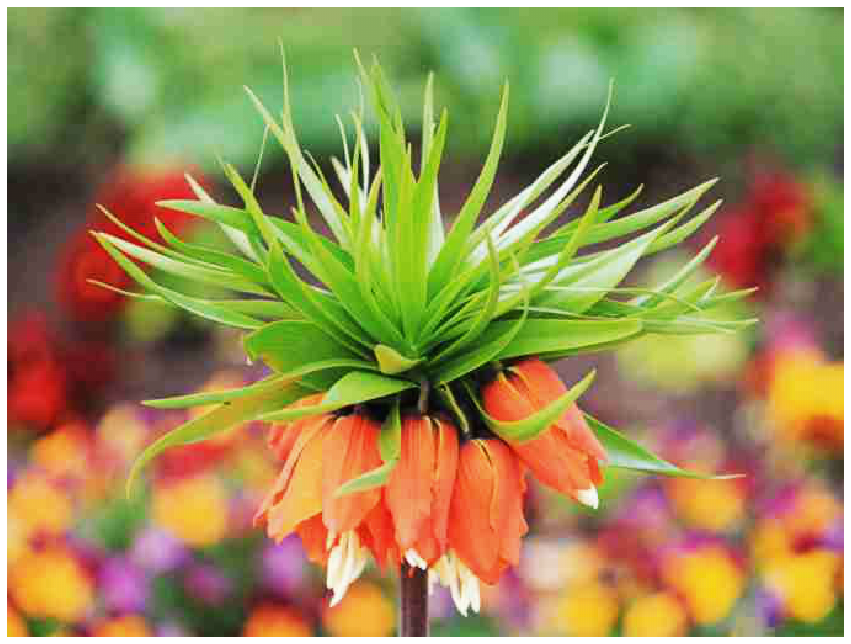

In [37]:
Image(img_hr).show(figsize=(15,15))

In [ ]:
learn_gen = None
gc.collect()